In [1]:
import xarray as xr
import numpy as np
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

from plotting_maps.acs_plotting_maps import plot_acs_hazard_multi, plot_acs_hazard, plot_data, cmap_dict, regions_dict
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar

In [2]:
ssp_colors = {"evaluation":"k",
              "historical":"grey",
              "ssp585":(149/255,27/255,30/255),
              "ssp370":(231/255,29/255,37/255),
              "ssp245":(247/255,148/255,32/255),
              "ssp126":(23/255,60/255,102/255),
              "ssp119":(0/255,173/255,207/255),}

In [3]:
list_evaluation = ['evaluation_BARRA-R_r1i1p1f1',
                   'evaluation_ERA5_r1i1p1f1',
                  ]

list_historical = ['historical_ACCESS-CM2_r4i1p1f1', 
                   'historical_ACCESS-ESM1-5_r6i1p1f1',
                   'historical_CESM2_r11i1p1f1', 
                   'historical_CMCC-ESM2_r1i1p1f1',
                   'historical_EC-Earth3_r1i1p1f1',
                   'historical_MPI-ESM1-2-HR_r1i1p1f1',
                   'historical_NorESM2-MM_r1i1p1f1',
                  ]

list_ssp126 = [
                 'ssp126_ACCESS-CM2_r4i1p1f1', # need to fix this one
                 'ssp126_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp126_CESM2_r11i1p1f1',
                 'ssp126_CMCC-ESM2_r1i1p1f1',
                 'ssp126_EC-Earth3_r1i1p1f1',
                 'ssp126_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp126_NorESM2-MM_r1i1p1f1',
              ]

list_ssp370 = ['ssp370_ACCESS-CM2_r4i1p1f1',
                 'ssp370_ACCESS-ESM1-5_r6i1p1f1',
                 'ssp370_CESM2_r11i1p1f1',
                 'ssp370_CMCC-ESM2_r1i1p1f1',
                 'ssp370_EC-Earth3_r1i1p1f1',
                 'ssp370_MPI-ESM1-2-HR_r1i1p1f1',
                 'ssp370_NorESM2-MM_r1i1p1f1',
              ]

list_ssp585 = ['ssp585_ACCESS-CM2_r4i1p1f1',
                 'ssp585_EC-Earth3_r1i1p1f1']

list_future = list_ssp126 + list_ssp370 + list_ssp585

In [4]:
evaluation_kstest = pd.read_csv("/home/563/gt3409/turbulence_AUSCAT/evaluation_kstest_table.csv", index_col=0,).replace(np.nan, "")
evaluation_ttest = pd.read_csv("/home/563/gt3409/turbulence_AUSCAT/evaluation_ttest_p33_table.csv", index_col=0,)[["p33_pvalue", "significance"]].replace(np.nan, "")

In [5]:
evaluation_combined = pd.concat([evaluation_kstest, evaluation_ttest], axis=1, join="inner")
evaluation_combined["combined_significance"] = evaluation_kstest["significance"] + evaluation_ttest["significance"]
evaluation_combined

,sample1,sample2,time_selection,mon/seas/yr,pvalue,significance,p33_pvalue,significance,combined_significance
0,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,annual,year,0.310,,0.045,*,*
1,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,DJF,season,0.999,,0.209,,
2,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,MAM,season,0.150,,0.150,,
3,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,JJA,season,0.082,,0.158,,
4,evaluation_BARRA-R_r1i1p1f1,historical_ACCESS-CM2_r4i1p1f1,SON,season,0.212,,0.099,,
...,...,...,...,...,...,...,...,...,...
114,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,August,month,0.018,*,0.167,,*
115,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,September,month,0.001,**,0.149,,**
116,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,October,month,0.198,,0.207,,
117,evaluation_BARRA-R_r1i1p1f1,historical_NorESM2-MM_r1i1p1f1,November,month,0.948,,0.178,,


# Time series MOG windspeed

In [6]:
turbulence_index = "windspeed"
ds = xr.open_dataset("/g/data/v46/gt3409/turbulence_AUSCAT/windspeed-freq-above-p99_AUS-15_BOM_BARPA-R_v1-r1_6hr_monthly.nc")

In [7]:
ds


<xarray.Dataset> Size: 296kB
Dimensions:    (run: 24, time: 1464)
Coordinates:
  * time       (time) datetime64[ns] 12kB 1979-01-31 1979-02-28 ... 2100-12-31
    pressure   int64 8B ...
  * run        (run) <U33 3kB 'evaluation_BARRA-R_r1i1p1f1' ... 'ssp585_EC-Ea...
Data variables:
    windspeed  (run, time) float64 281kB ...

using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']


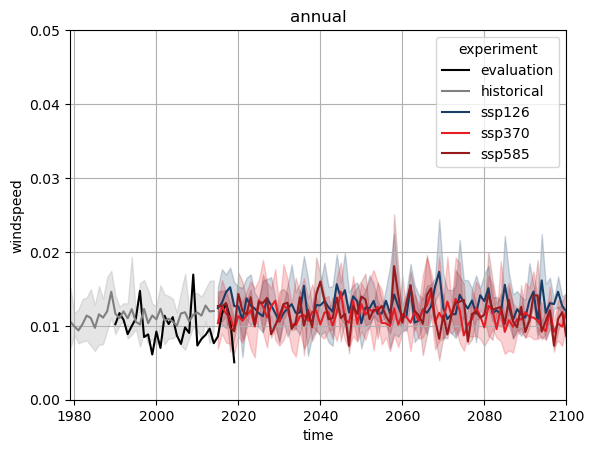

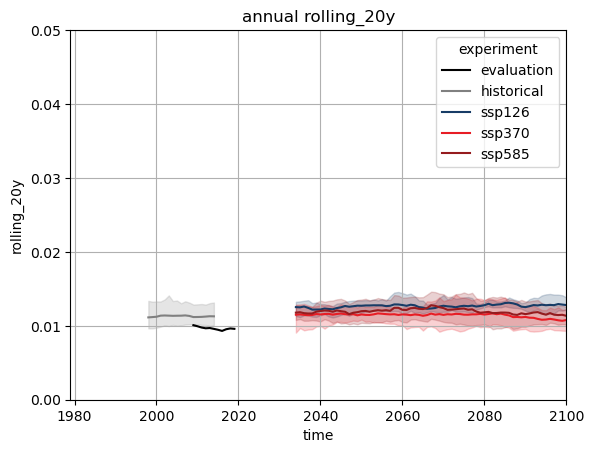

In [8]:
# for annual:
time_selection = "annual"
significance_list = list(evaluation_combined[(evaluation_combined["time_selection"]=="annual") 
                         & (evaluation_combined["combined_significance"].isin(["", "*",]))]["sample2"])

print(f"using {significance_list}")
run_list = ['evaluation_BARRA-R_r1i1p1f1'] + [experiment + run[10:]
                                              for experiment in ["historical", "ssp126", "ssp370", "ssp585"] 
                                              for run in significance_list]


# get the relevant runs and resample to annual
ds_ann = ds.sel(run = ds["run"].isin(run_list)).resample({"time":"YS"}).mean()

for window_size in [5,10,20]:
    ds_ann[f"rolling_{window_size}y"] = ds_ann[turbulence_index].rolling(time = window_size).mean()

df = ds_ann.to_dataframe().reset_index()
df["experiment"] = [x.split("_")[0] for x in df["run"]]

# plot it
plt.figure()
sns.lineplot(df, x="time", y="windspeed", hue="experiment", errorbar=('ci', 100), palette=ssp_colors,)
plt.title( f"{time_selection}")
plt.ylim((0, 0.05))
plt.xlim((datetime.date(1979,1,1), datetime.date(2100,1,1)))
plt.grid()

for window_size in [20]: #[5,10,20]:
    plt.figure()
    sns.lineplot(df, x="time", y=f"rolling_{window_size}y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors,)
    plt.title( f"{time_selection} rolling_{window_size}y")
    plt.ylim((0, 0.05))
    plt.xlim((datetime.date(1979, 1, 1), datetime.date(2100, 1, 1)))
    plt.grid()

using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']
using ['historical_ACCESS-CM2_r4i1p1f1', 'historical_ACCESS-ESM1-5_r6i1p1f1', 'historical_CESM2_r11i1p1f1', 'historical_CMCC-ESM2_r1i1p1f1', 'historical_EC-Earth3_r1i1p1f1', 'historical_NorESM2-MM_r1i1p1f1']


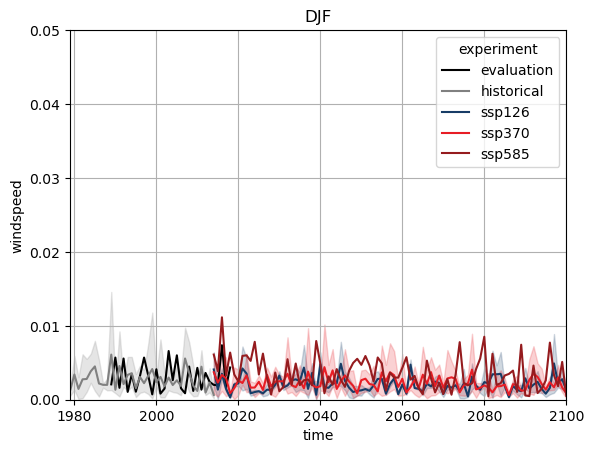

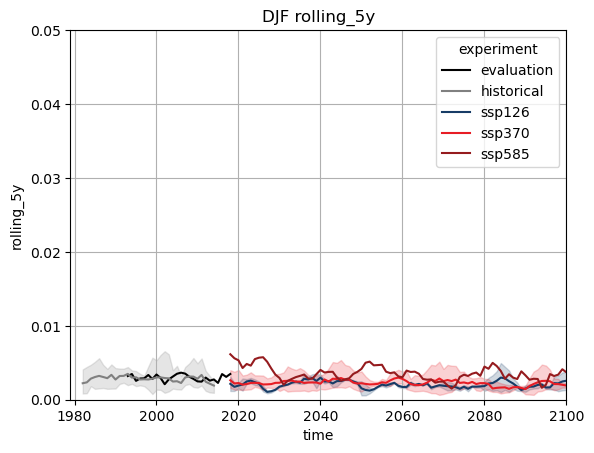

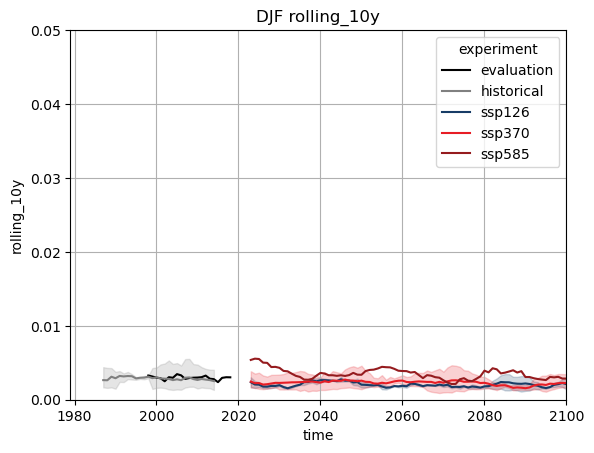

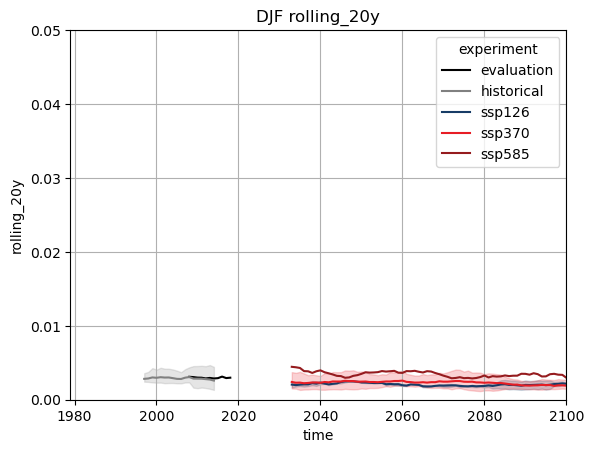

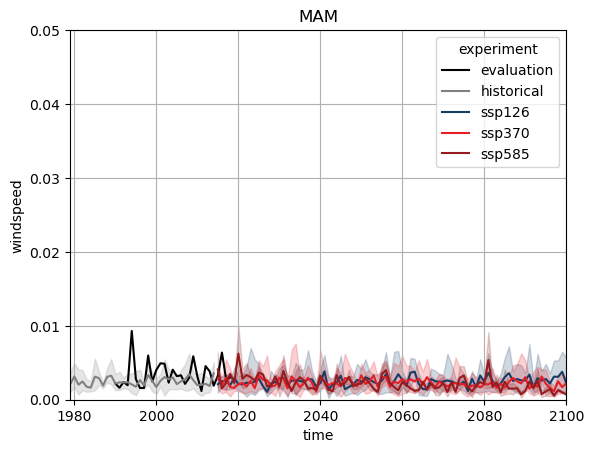

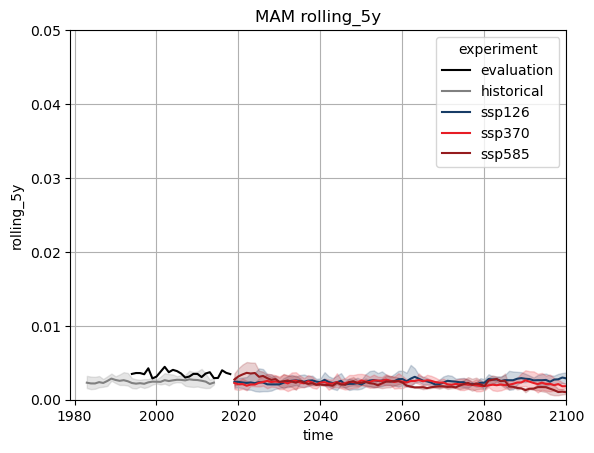

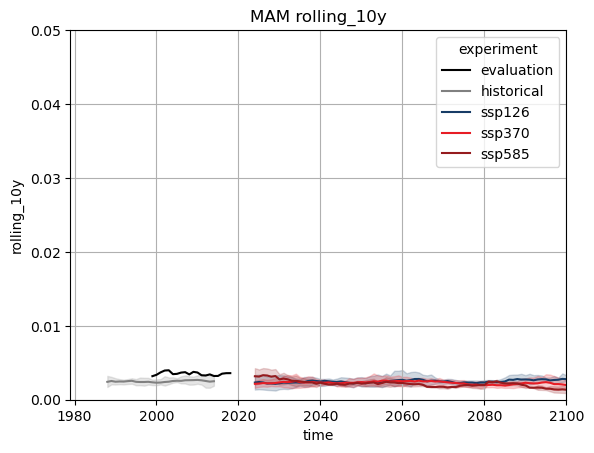

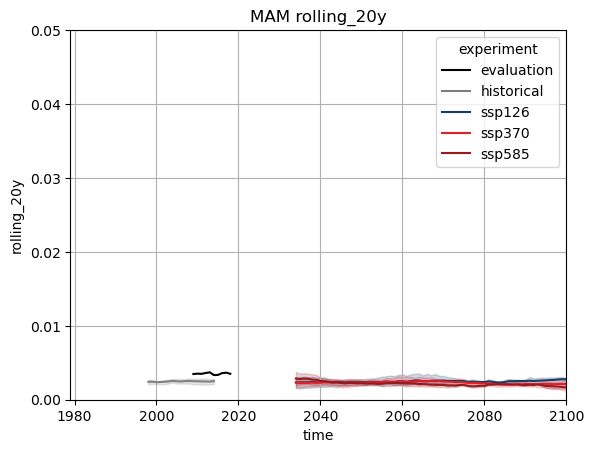

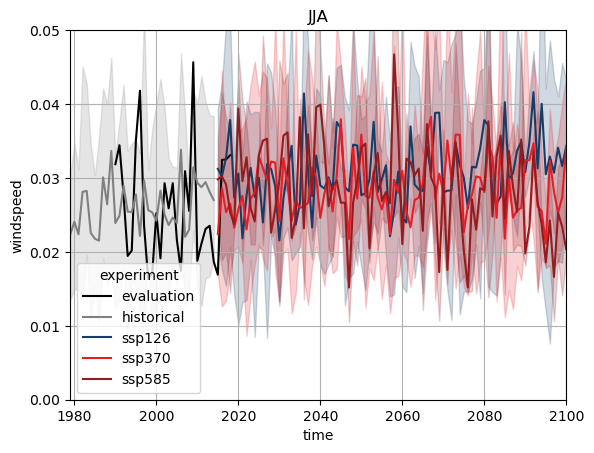

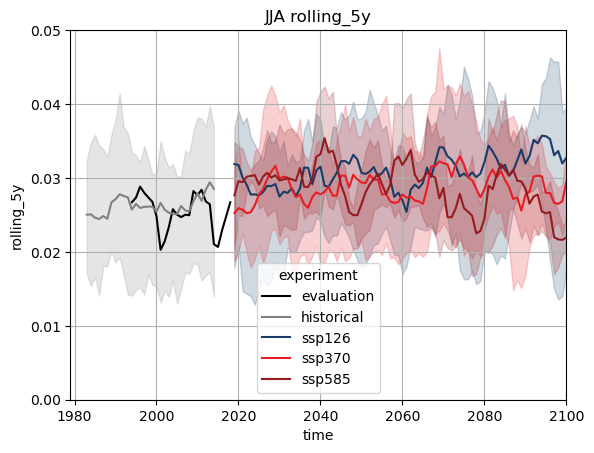

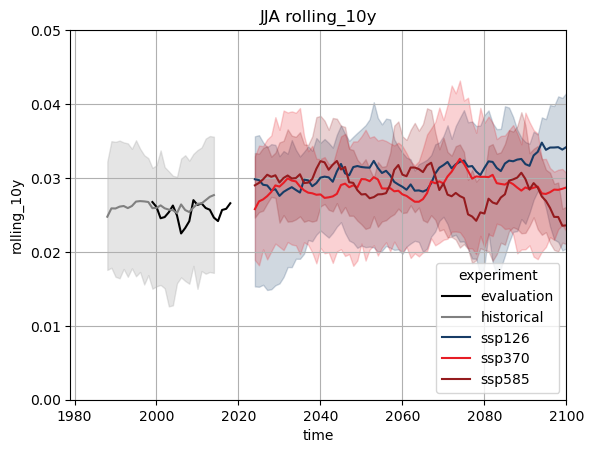

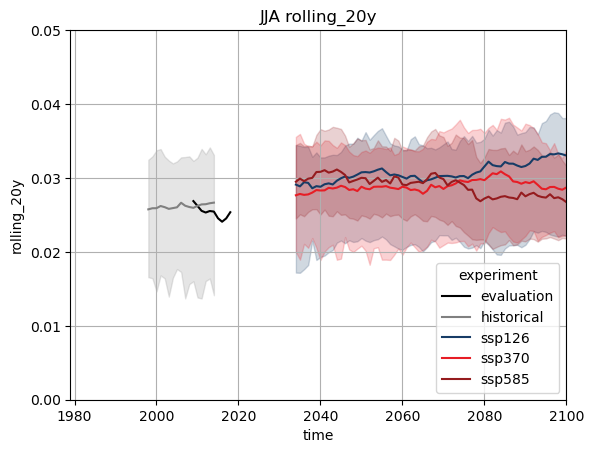

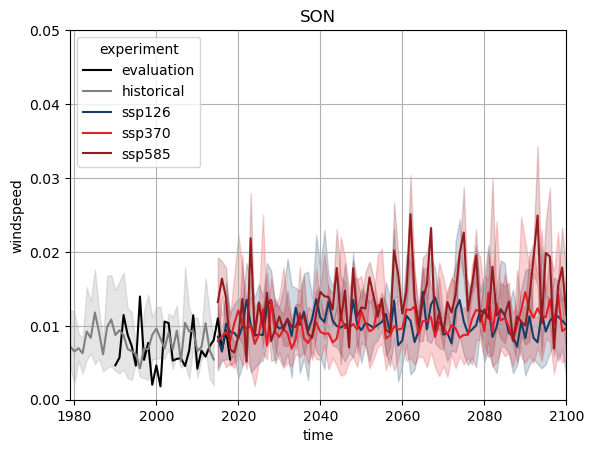

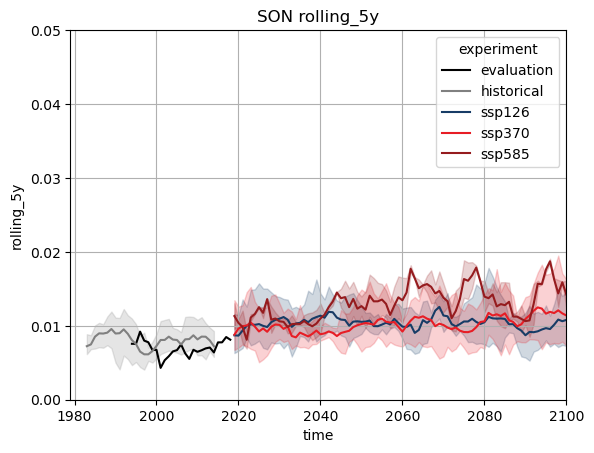

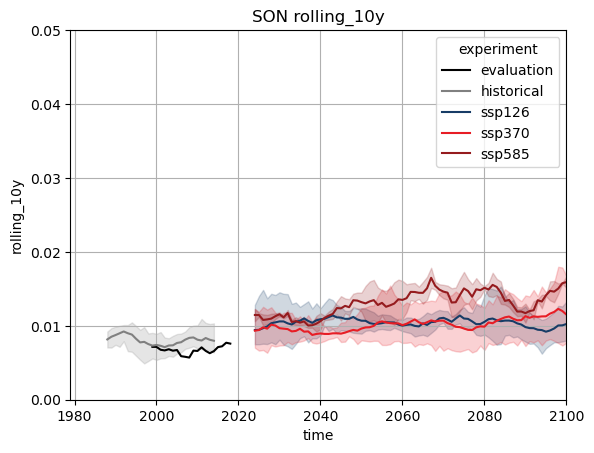

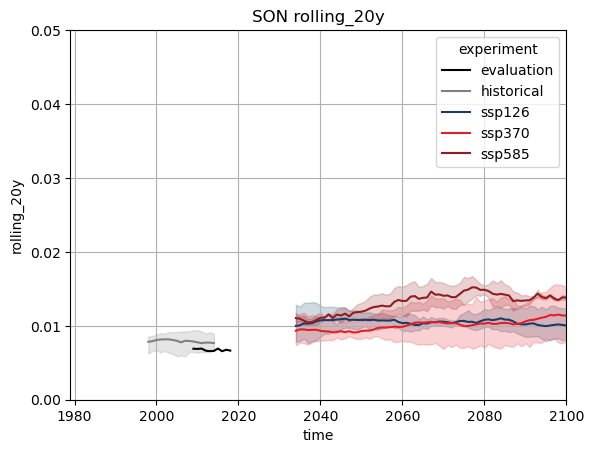

In [9]:
# for season:
for time_selection in ["DJF", "MAM", "JJA", "SON"]:
    significance_list = list(evaluation_combined[(evaluation_combined["time_selection"]==time_selection) 
                             & (evaluation_combined["combined_significance"].isin(["", "*",]))]["sample2"])
    
    print(f"using {significance_list}")
    run_list = ['evaluation_BARRA-R_r1i1p1f1'] + [experiment + run[10:]
                                                  for experiment in ["historical", "ssp126", "ssp370", "ssp585"] 
                                                  for run in significance_list]
    
    
    # get the relevant runs and resample to annual
    ds_ann = ds.sel({"time": (ds["time"].dt.season==time_selection), 
                     "run": ds["run"].isin(run_list)}).resample({"time":"QS-DEC"}).mean().resample({"time":"YS"}).mean()
    
    for window_size in [5,10,20]:
        ds_ann[f"rolling_{window_size}y"] = ds_ann[turbulence_index].rolling(time = window_size).mean()
    
    df = ds_ann.to_dataframe().reset_index()
    df["experiment"] = [x.split("_")[0] for x in df["run"]]
    
    # plot it
    plt.figure()
    sns.lineplot(df, x="time", y="windspeed", hue="experiment", errorbar=('ci', 100), palette=ssp_colors,)
    plt.title( f"{time_selection}")
    plt.ylim((0, 0.05))
    plt.xlim((datetime.date(1979,1,1), datetime.date(2100,1,1)))
    plt.grid()
    
    for window_size in [5,10,20]:
        plt.figure()
        sns.lineplot(df, x="time", y=f"rolling_{window_size}y", hue="experiment", errorbar=('ci', 100), palette=ssp_colors,)
        plt.title( f"{time_selection} rolling_{window_size}y")
        plt.ylim((0, 0.05))
        plt.xlim((datetime.date(1979, 1, 1), datetime.date(2100, 1, 1)))
        plt.grid()

# maps

In [10]:
mid_lat_slice = slice(-50,-25)
lon_slice = slice(90,195)
baseline_time_range = np.arange(1990,2009+1)
baseline_time_slice = slice("1990", "2009")

turbulence_index = "windspeed"

In [11]:
evaluation = list_evaluation[1]
ds = xr.open_mfdataset([f"/scratch/v46/gt3409/TMP_windspeed-freq-above-p99/TMP_windspeed-monthly-freq-above-p99_{run}.nc" 
                        for run in [evaluation]],
                      concat_dim="run",
                      combine="nested",).sel({"lon":lon_slice, "time": baseline_time_slice})

ds=ds.load()

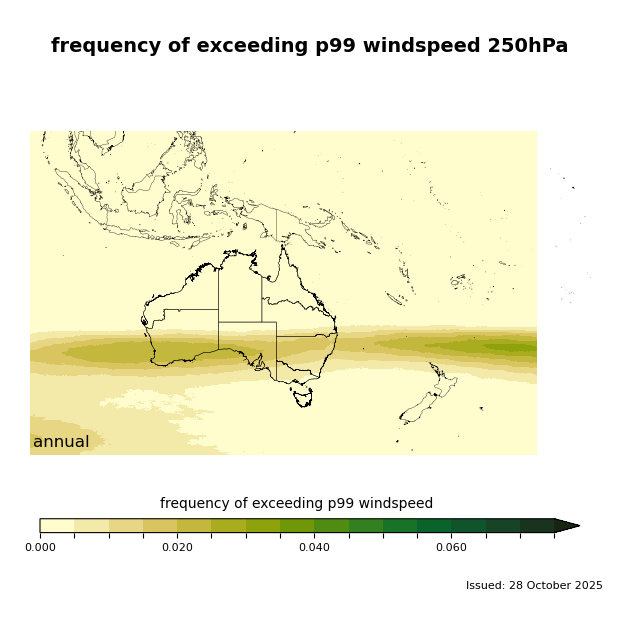

In [12]:
# annual
fig, axs = plot_acs_hazard_multi(nrows=1, 
                      ncols=1, 
                      ds_list=[ds.sel({"time":baseline_time_slice}).resample({"time":"YE"}).mean().mean(["time", "run"])[turbulence_index]],
                      mask_not_australia=False,
                      ticks=np.arange(0.0, 0.08, 0.005),
                      tick_interval=4,
                      cbar_extend="max",
                      cbar_label=f"frequency of exceeding p99 {turbulence_index}",
                      figsize=(6, 6),
                      title=f"frequency of exceeding p99 {turbulence_index} 250hPa",
                      subplot_titles="annual",
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["ipcc_wind_seq"],
                      watermark="",
                      show_copyright=False,
                     );


    


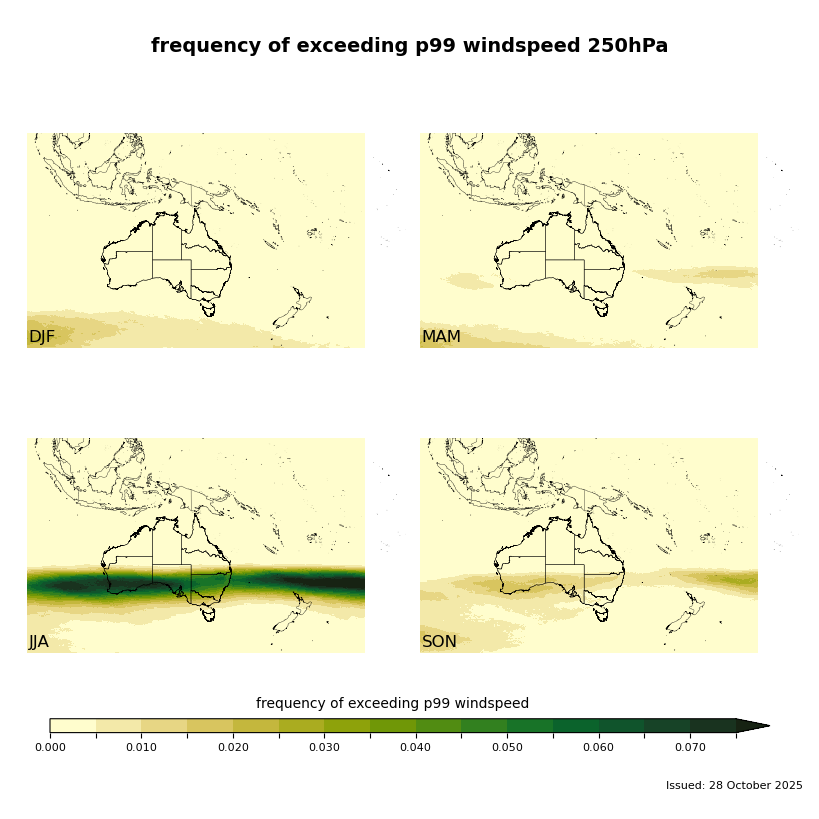

In [13]:
# seasons
ds_seas = ds.resample({"time":"QS-DEC"}).mean()
season_list = ["DJF", "MAM", "JJA", "SON"]

fig, axs = plot_acs_hazard_multi(nrows=2, 
                      ncols=2, 
                      ds_list=[ds_seas.sel({"time": ds_seas.time.dt.season == time_selection})\
                               .resample({"time":"YE"}).mean()\
                               .sel({"time":baseline_time_slice})\
                               .mean(["time", "run"])[turbulence_index]\
                               for time_selection in season_list],
                      mask_not_australia=False,
                      ticks=np.arange(0.0, 0.08, 0.005),
                      tick_interval=2,
                      cbar_extend="max",
                      cbar_label=f"frequency of exceeding p99 {turbulence_index}",
                      figsize=(8, 8),
                      title=f"frequency of exceeding p99 {turbulence_index} 250hPa",
                      subplot_titles=season_list,
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["ipcc_wind_seq"],
                      watermark="",
                      show_copyright=False,
                     );


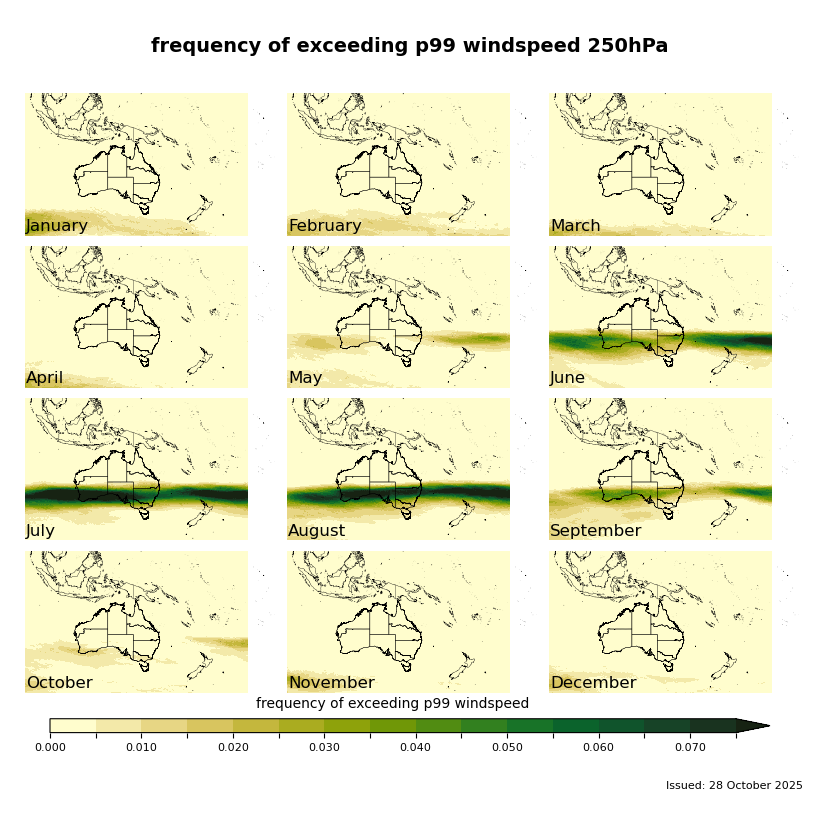

In [14]:
# months
fig, axs = plot_acs_hazard_multi(nrows=4, 
                      ncols=3, 
                      ds_list=[ds.sel({"time": ds.time.dt.month == time_selection})\
                               .resample({"time":"YE"}).mean()\
                               .sel({"time":baseline_time_slice})\
                               .mean(["time", "run"])[turbulence_index]\
                               for time_selection in np.arange(1,12+1)],
                      mask_not_australia=False,
                      ticks=np.arange(0, 0.08, 0.005),
                      tick_interval=2,
                      cbar_extend="max",
                      cbar_label=f"frequency of exceeding p99 {turbulence_index}",
                      figsize=(8, 8),
                      title=f"frequency of exceeding p99 {turbulence_index} 250hPa",
                      subplot_titles=[calendar.month_name[time_selection] for time_selection in np.arange(1,12+1)],
                      xlim=(88.04 , 207.9),
                      ylim=(-53.58 , 13.63),
                      coastlines=True,
                      projection=ccrs.PlateCarree(130),
                      cmap=cmap_dict["ipcc_wind_seq"],
                      watermark="",
                      show_copyright=False,
                     );